# NLP From Scratch: Generating Names with a Character-Level RNN

In [461]:
import os
import zipfile
import requests

data_dir = 'data/data/names/'
zip_path = 'data/data.zip'
url = 'https://download.pytorch.org/tutorial/data.zip'

try:
    # Check if the target directory already exists
    if not os.path.exists(data_dir):
        # Ensure the parent directory exists
        os.makedirs(os.path.dirname(zip_path), exist_ok=True)

        # Download the file
        print("Downloading data...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(zip_path, 'wb') as file:
                file.write(response.content)  # Write the content of the request to a file
        else:
            raise Exception(f"Failed to download file from {url}, status code: {response.status_code}")

        # Extract the zip file
        print("Extracting data...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('data')

        print("Data was successfully downloaded and extracted.")

        # Clean up the zip file
        os.remove(zip_path)
    else:
        print("Data already exists. No download needed.")
except Exception as e:
    print(f"An error occurred: {e}")

Data already exists. No download needed.


In [462]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError(
        "Data not found. Please ensure the following steps are completed:\n"
        "- Verify that the directory 'data/data/names/' exists and contains the required files.\n"
        "- If the directory or files are missing, download the data from 'https://download.pytorch.org/tutorial/data.zip'.\n"
        "- Extract the contents of the zip file into the current working directory."
    )

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
all_characters = set

# categories: 18 ['Spanish', 'Vietnamese', 'Italian', 'Russian', 'Greek', 'French', 'Scottish', 'Japanese', 'Arabic', 'Portuguese', 'Polish', 'Dutch', 'Czech', 'English', 'Irish', 'German', 'Korean', 'Chinese']
O'Neal


## Creating the Network

In [463]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    """
    A Recurrent Neural Network (RNN) designed for generating names character by character.
    It takes as input a category (e.g., a language), a character, and a hidden state,
    and predicts the next character in the sequence while updating its hidden state.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Linear layer to combine category, input, and previous hidden state into the new hidden state.
        # i2h stands for "input to hidden"; it transforms the combined input into the next hidden state.
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        # Linear layer to transform the combined category, input, and hidden state into the raw output (input to output)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        # Linear layer to refine the output using the hidden state and previous output
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        # Dropout for regularization to prevent overfitting
        self.dropout = nn.Dropout(0.1)
        # LogSoftmax activation for generating log probabilities of the output classes
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        # Combine category, input, and previous hidden state into a single tensor
        input_combined = torch.cat((category, input, hidden), 1)
        # Compute the new hidden state
        hidden = self.i2h(input_combined)
        # Generate raw output logits from the input and category
        output = self.i2o(input_combined)
        # Combine hidden state and raw output for refinement
        output_combined = torch.cat((hidden, output), 1)
        # Apply the final linear transformation, dropout, and softmax
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Initialize the hidden state tensor with zeros
        return torch.zeros(1, self.hidden_size)

In [464]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [465]:
# Function to generate a one-hot encoded tensor representing the category.
# The function indexes the category position in `all_categories` and sets the corresponding position in the tensor to 1.
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


# Function to generate a one-hot encoded tensor for the input string (line).
# Each character in the input string is represented as a one-hot vector, and all such vectors are stacked together.
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


# Function to create a LongTensor representing the target output sequence.
# Each character is encoded as its index in `all_letters`, with the last index representing the EOS marker.
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  #EOS
    return torch.LongTensor(letter_indexes)

In [466]:
# Make category, input, and target tensors form a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Training the Network

In [467]:
criterion = nn.NLLLoss()

learning_rate = 0.0005
epochs = 5  # Define the number of epochs for training

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0  # Initialize loss for the current iteration
    correct_predictions = 0  # Initialize correct predictions counter

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

        # Track the correct predictions
        topv, topi = output.topk(1)
        if topi[0].item() == target_line_tensor[i].item():
            correct_predictions += 1

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    accuracy = correct_predictions / input_line_tensor.size(0)  # Calculate accuracy for the example
    return output, loss.item() / input_line_tensor.size(0), accuracy

# New wrapper function to train over multiple epochs
def train_with_epochs(epochs, n_iters):
    for epoch in range(1, epochs + 1):
        total_loss = 0  # Reset total loss for the current epoch
        total_accuracy = 0  # Reset total accuracy for the current epoch
        start = time.time()  # Track the start time for the epoch
        print(f"Epoch {epoch}/{epochs} Starting...")

        for iter in range(1, n_iters + 1):
            category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
            _, loss, accuracy = train(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
            total_accuracy += accuracy

            # Print progress at regular intervals
            if iter % print_every == 0:
                print(f'{timeSince(start)} (Iter {iter}/{n_iters}, Epoch {epoch}) Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

        avg_loss = total_loss / n_iters
        avg_accuracy = total_accuracy / n_iters * 100  # Calculate average accuracy as a percentage
        print(f"Epoch {epoch}/{epochs} completed. Average Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%\n")

In [468]:
import time
import math


def timeSince(since):
    now = time.time()  # Get the current time in seconds since the epoch.
    s = now - since  # Calculate the elapsed time in seconds.
    m = math.floor(s / 60)  # Convert the elapsed time to minutes.
    s -= m * 60  # Calculate the remaining seconds after minutes.
    return '%dm %ds' % (m, s)  # Format the elapsed time as a string "Xm Ys".

In [469]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()
train_with_epochs(epochs=epochs, n_iters=n_iters)

# for iter in range(1, n_iters + 1):
#     output, loss = train_with_epochs(epochs=epochs, n_iters=n_iters)
#
#     total_loss += loss
#
#     if iter % print_every == 0:
#         print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
#
#     if iter % plot_every == 0:
#         all_losses.append(total_loss / plot_every)
#         total_loss = 0

Epoch 1/5 Starting...
0m 3s (Iter 5000/100000, Epoch 1) Loss: 2.8933, Accuracy: 0.0000
0m 7s (Iter 10000/100000, Epoch 1) Loss: 3.2078, Accuracy: 0.1429
0m 10s (Iter 15000/100000, Epoch 1) Loss: 3.1571, Accuracy: 0.1333
0m 14s (Iter 20000/100000, Epoch 1) Loss: 2.7336, Accuracy: 0.2500
0m 17s (Iter 25000/100000, Epoch 1) Loss: 2.8372, Accuracy: 0.1429
0m 21s (Iter 30000/100000, Epoch 1) Loss: 3.3337, Accuracy: 0.2727
0m 25s (Iter 35000/100000, Epoch 1) Loss: 2.2124, Accuracy: 0.4286
0m 28s (Iter 40000/100000, Epoch 1) Loss: 2.5239, Accuracy: 0.3333
0m 32s (Iter 45000/100000, Epoch 1) Loss: 2.3395, Accuracy: 0.2000
0m 35s (Iter 50000/100000, Epoch 1) Loss: 2.8160, Accuracy: 0.1250
0m 39s (Iter 55000/100000, Epoch 1) Loss: 1.6864, Accuracy: 0.6667
0m 43s (Iter 60000/100000, Epoch 1) Loss: 2.3669, Accuracy: 0.2500
0m 46s (Iter 65000/100000, Epoch 1) Loss: 2.6704, Accuracy: 0.2000
0m 50s (Iter 70000/100000, Epoch 1) Loss: 2.0719, Accuracy: 0.5000
0m 53s (Iter 75000/100000, Epoch 1) Loss: 2

## Plotting the Losses

Text(0, 0.5, 'Loss')

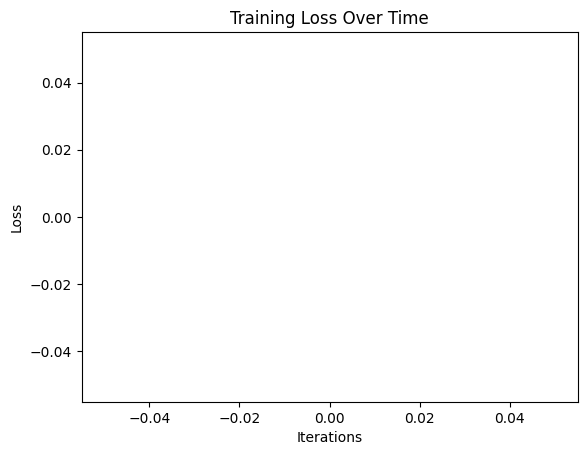

In [470]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.title("Training Loss Over Time")  # Add title
plt.xlabel("Iterations")  # Add x-axis label
plt.ylabel("Loss")  # Add y-axis label

## Sampling the Network

In [471]:
# Maximum number of characters to be generated in a name
max_length = 20


# Sample from a category and starting letter
# The function generates a name by sampling one character at a time, starting with 'start_letter'.
# It uses the trained RNN to predict the next character based on the category and previous hidden state.
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        # Create one-hot encoded tensors for the category and the starting letter
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        # Initialize the hidden state for the RNN
        hidden = rnn.initHidden()

        # Initialize the generated name as the starting letter
        output_name = start_letter

        for i in range(max_length):
            # Get output and updated hidden state from the RNN
            output, hidden = rnn(category_tensor, input[0], hidden)
            # Get the most likely character index (highest probability)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            # Stop if the EOS (End of String) index is reached
            if topi == n_letters - 1:
                break
            else:
                # Append the predicted character to the output name
                letter = all_letters[topi]
                output_name += letter
            # Create the input tensor for the next step using the predicted character
            input = inputTensor(letter)

        return output_name


# Get multiple samples from one category and multiple starting letters
# For a given category (e.g., language), the function generates names starting with each letter in 'start_letters'.
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


# Generate and print samples for selected categories and starting letters
samples('Russian', 'RUS')  # Names in the Russian category starting with 'R', 'U', and 'S'
samples('German', 'GER')  # Names in the German category starting with 'G', 'E', and 'R'
samples('Spanish', 'SPA')  # Names in the Spanish category starting with 'S', 'P', and 'A'
samples('Chinese', 'CHI')  # Names in the Chinese category starting with 'C', 'H', and 'I'

Romankov
Urishin
Sakovanov
Grenter
Esterr
Roser
Santar
Pantera
Alaran
Che
Han
Ina
